# Intro to Jax
*Gert-Jan Both, 16/12/12, too late o'clock*

In [ ]:
# Install latest Flax version from Github.
!pip install git+https://github.com/google/flax

  Cloning https://github.com/google/flax to /tmp/pip-req-build-lij0tt3g
  Running command git clone -q https://github.com/google/flax /tmp/pip-req-build-lij0tt3g
  Created wheel for flax: filename=flax-0.3.0-cp36-none-any.whl size=156513 sha256=14ff7fb53a553ecb339964d198a3c5b9b7cf9ae81ccbc101bb49d9045b52c16f
  Stored in directory: /tmp/pip-ephem-wheel-cache-5ypm_n3k/wheels/3d/26/f4/0ea6051d7352289d9e4f8178348452b35a9a97bde6035405a5
Successfully built flax


In [ ]:
# %% Imports
import jax
from jax import random, numpy as jnp
from flax import optim, linen as nn
from jax.scipy.special import erfc

from time import time
from typing import Sequence
from functools import partial

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%config InlineBackend.figure_format = 'svg'

## Creating dataset

Let's start by creating a dataset to train the network. As always, we use the infamous Burgers burgers equation with a delta peak initial condition:

In [ ]:
def burgers(x, t, v, A):
    R = A / (2 * v)  
    z = x / jnp.sqrt(4 * v * t)

    u = (
        jnp.sqrt(v / (jnp.pi * t))
        * ((jnp.exp(R) - 1) * jnp.exp(-(z ** 2)))
        / (1 + (jnp.exp(R) - 1) / 2 * erfc(z))
    )
    return u

We could've used the version already implemented in deepmod, but I wanted the notebook to be independent of other code. Simply replacing torch by jnp gives the jax version. Now we create a grid and the data:

In [ ]:
x = jnp.linspace(-3, 4, 100)
t = jnp.linspace(0.5, 5.0, 20)

t_grid, x_grid = jnp.meshgrid(t, x, indexing='ij')

u = burgers(x_grid, t_grid, 0.1, 1.0)

Text(0.5, 0, 'x')

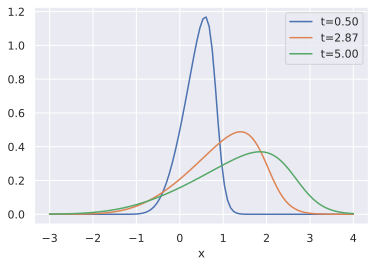

In [ ]:
frame = 0
plt.plot(x, u[frame, :], label=f't={t[frame]:.2f}')

frame = 10
plt.plot(x, u[frame, :], label=f't={t[frame]:.2f}')

frame = -1
plt.plot(x, u[frame, :] ,label=f't={t[frame]:.2f}')

plt.legend()
plt.xlabel('x')

Now let's turn it into neural network ready tensors:

In [ ]:
X_train = jnp.concatenate([t_grid.reshape(-1, 1), x_grid.reshape(-1, 1)], axis=1)
y_train = u.reshape(-1, 1)

Jax automatically moves these to and from the gpu, so no need to worry about that :-).

## Constructing the model

Jax itself doesn't do neural networks and all that jazz, it *only* gives differentiable functions and functions to calculate gradients etc. We use flax (https://github.com/google/flax, developed by google) as our NN library. There are several options out there, including trax (also developed by google), haiku (developed by deepmind) and objax (developed by an engineer from google). I choose flax since this seems to stay the closest to Jax itself (i.e. it's a very simple library) and it's pretty well documented. A lot of the stuff I'm about to explain is also in here: https://flax.readthedocs.io/en/latest/notebooks/flax_basics.html#Defining-your-own-models , but more condensed in some parts and longer in others.

Below we define a simple multi layer perceptron. It seems fairly close to how you would do it in pytorch, but underneath are big differences:
* In flax, a model is python dataclass instead of a normal class (see https://stackoverflow.com/questions/47955263/what-are-data-classes-and-how-are-they-different-from-common-classes for an explanation.) With dataclasses, we don't define an __init__ but simply list the variables as a list underneath the class name. Any initialization can be done by defining a method named setup()
* The __call__ function takes the place of the forward function. 
* Using the @compact decorator lazily initializes the layers in the function, meaning that we can simply define a network and they get initialized and shape inferred the first time we run it.
* **The model does not store its parameters**. The way I like to think about it is that the model defines *how* to combine the parameters and the input data (a bit like a blueprint), but its up to you to provide those.
* Although we have __call__, running model(x) will fail. To run a forward pass, run model.apply(params, x)

In [ ]:
class MLP(nn.Module):
    """Simple feed-forward NN.
    """

    features: Sequence[int]  # this is dataclass, so we dont use __init__

    @nn.compact  # this function decorator lazily intializes the model, so it makes the layers the first time we call it
    def __call__(self, inputs):
        x = inputs  # we overwrite x so we copy it to a new tensor
        for feature in self.features[:-1]:
            x = nn.tanh(nn.Dense(feature)(x))
        x = nn.Dense(self.features[-1])(x)
        return x

We instantiate the model in the training section.

## Constructing a training function

Jax has some pretty sweet features, one of which is the magical vmap. It allows us to define a function on a single datapoint, and then use vmap over it to automatically apply it over multiple samples. Below we define the squared_error() on a single sample (note there's no axis arguments anywhere) and then call vmap on it to perform it over all samples. in_axes (0,0) says 'apply it to the 0th axis of the first and second argument', i.e. the samples axis from y:

In [ ]:
def mse_loss(y_pred, y):
    def squared_error(y, y_pred):
        return jnp.inner(y - y_pred, y - y_pred) / 2.0
    return jnp.mean(jax.vmap(squared_error, in_axes=(0, 0), out_axes=0)(y, y_pred), axis=0)

This is the most complex and dense part of the whole thing and i'll try to explain it as best as I can. Jax has a function known as jit which compiles python code in the background the first time you call it to highly optimized code. Since one step of our training loop consists of the forward pass up to updating the parameters, this is what we want to jit. So here we have three levels:
1. The outer level train_step takes in the model and our training data and return a highly optimized function which only takes in the optimizer as argument (see next section how this works.)
2. The second level step() updates the parameters in the optimizer, data and model and returns the optimizer to be used for the next update.
3. The innermost level loss_fn performs the forward pass and calculates the loss. 

In reverse, we can say that 3) Calculates the loss, 2) Updates the model based on the loss and 1) Builds and returns a highly optimized version of 2. There's a few new functions in the code below:
1. jax.value_and_grad(func) returns a function which calculates the gradient and value of func.
2. opt.apply_gradient(grad) updates the parameters given the gradients.
3. partial is basically what lambda x: function(x) does, but a bit nicer.
4. Jit is the optimized compilation.

**This took me a while to figure out, but I think it's the most clear I can implement it for now. Do come back here after going through the whole notebook and it'll make more sense.**


In [ ]:
def train_step(model, x, y):
    """Constructs a fast update given a loss function.
    """

    def step(opt, x, y, model):
        def loss_fn(params):
            prediction = model.apply(params, x)
            loss = mse_loss(prediction, y)
            return loss

        grad_fn = jax.value_and_grad(loss_fn)
        loss, grad = grad_fn(opt.target)
        opt = opt.apply_gradient(grad)  # Return the updated optimizer with parameters.
        return opt, loss

    return jax.jit(partial(step, x=x, y=y, model=model))

# Building and running the model

For the final section, let's build and run our model. We instantiate our model as usual:

In [ ]:
model = MLP(features=[50, 50, 1])

However, we said that it doesn't contain the parameters so we need to instantiate those as well by calling model.init(random_key, mock_data). The random key is used to generate the random set of weights (it works a bit different due to jax' functional nature, but don't worry too much about it for now) and some mock data to infer the shapes:

In [ ]:
key = random.PRNGKey(42)
params = model.init(key, X_train[[0], :])

Next up is the optimizer. We define an optimizer as usual, and then use optimizer.create() to set which params to update. The updated params are now in the optimizer and accesible with optimizer.target(), as we saw in the previous section.

In [ ]:
optimizer = optim.Adam(learning_rate=1e-3)
optimizer = optimizer.create(params)

We now call train_step with our model and data to build an update function and call this function once to trigger compilation:

In [ ]:
%%time
step = train_step(model, X_train, y_train)
_ = step(optimizer)  # triggering compilation

CPU times: user 648 ms, sys: 247 ms, total: 895 ms
Wall time: 2.54 s


Now we simply loop the update:

In [ ]:
%%time
max_epochs = 10001
for i in jnp.arange(max_epochs):
    optimizer, loss = step(optimizer)
    if i % 1000 == 0:
        print(f"Loss step {i}: {loss}")

Loss step 0: 0.2440507858991623
Loss step 1000: 0.00044235578388907015
Loss step 2000: 0.00016897446766961366
Loss step 3000: 5.521784260054119e-05
Loss step 4000: 1.732643249852117e-05
Loss step 5000: 7.956177796586417e-06
Loss step 6000: 4.9166023927682545e-06
Loss step 7000: 3.271194373155595e-06
Loss step 8000: 2.244077450086479e-06
Loss step 9000: 1.5853571539992117e-06
Loss step 10000: 1.1490334372865618e-06
CPU times: user 8.52 s, sys: 731 ms, total: 9.25 s
Wall time: 8.55 s


You're seeing that right: 10k iterations in < 10s (5s on our 2080super) thanks to Jax black magic (and a little bit of mine :-))